In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

[nltk_data] Downloading package stopwords to /Users/akash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('amazon_alexa.tsv', delimiter='\t')

In [4]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


                      variation  frequency
0                    Black  Dot        516
1              Charcoal Fabric         430
2  Configuration: Fire TV Stick        350
3                   Black  Plus        270
4                   Black  Show        265


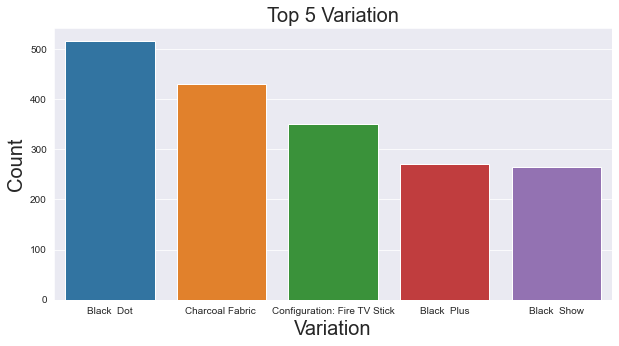

In [7]:
variation_label = df.variation.value_counts()[:5] 
variation_df = variation_label.reset_index()
variation_df.columns = ['variation', 'frequency']
print(variation_df)

plt.figure(figsize=(10, 5))
sns.barplot(x='variation', y='frequency', data=variation_df)
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20);

In [8]:
df.shape

(3150, 5)

In [9]:
df['len'] = df['verified_reviews'].map(len)
df['len']

0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: len, Length: 3150, dtype: int64

In [10]:
df.groupby('len').describe().sample(10)

rating                                              feedback            \
      count      mean       std  min  25%  50%  75%  max    count      mean   
len                                                                           
119     4.0  4.000000  1.414214  2.0  3.5  4.5  5.0  5.0      4.0  0.750000   
77     10.0  4.600000  0.966092  2.0  5.0  5.0  5.0  5.0     10.0  0.900000   
290     3.0  4.666667  0.577350  4.0  4.5  5.0  5.0  5.0      3.0  1.000000   
2393    1.0  5.000000       NaN  5.0  5.0  5.0  5.0  5.0      1.0  1.000000   
568     2.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0      2.0  1.000000   
236     2.0  4.000000  0.000000  4.0  4.0  4.0  4.0  4.0      2.0  1.000000   
155     5.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0      5.0  1.000000   
281     4.0  4.000000  1.414214  2.0  3.5  4.5  5.0  5.0      4.0  0.750000   
340     3.0  2.333333  2.309401  1.0  1.0  1.0  3.0  5.0      3.0  0.333333   
431     1.0  4.000000       NaN  4.0  4.0  4.0  4.0  4.0      1.0  1.000000   

                                          
           std  min   25%  50%  75%  max  
len                                       
119   0.500000  0.0  0.75  1.0  1.0  1.0  
77    0.316228  0.0  1.00  1.0  1.0  1.0  
290   0.000000  1.0  1.00  1.0  1.0  1.0  
2393       NaN  1.0  1.00  1.0  1.0  1.0  
568   0.000000  1.0  1.00  1.0  1.0  1.0  
236   0.000000  1.0  1.00  1.0  1.0  1.0  
155   0.000000  1.0  1.00  1.0  1.0  1.0  
281   0.500000  0.0  0.75  1.0  1.0  1.0  
340   0.577350  0.0  0.00  0.0  0.5  1.0  
431        NaN  1.0  1.00  1.0  1.0  1.0

In [11]:
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.187500   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.595303  1.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [12]:
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.241245  236.325955  1.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

   rating  frequency
0       5       2286
1       4        455
2       1        161
3       3        152
4       2         96


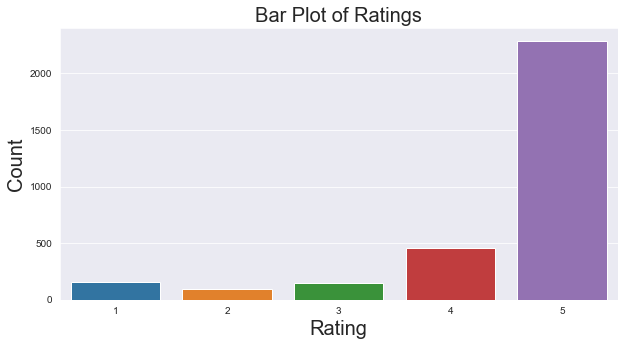

In [13]:
rating_label = df.rating.value_counts()
rating_df = rating_label.reset_index()
rating_df.columns = ['rating', 'frequency']
print(rating_df)

plt.figure(figsize=(10, 5))
sns.barplot(x='rating', y='frequency', data=rating_df)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);

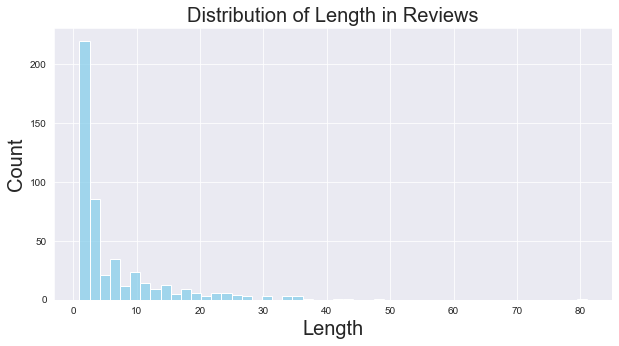

In [14]:
len_label = df['len'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Length in Reviews', fontsize=20);

In [15]:
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [16]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [17]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [18]:
df[df['len'] == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

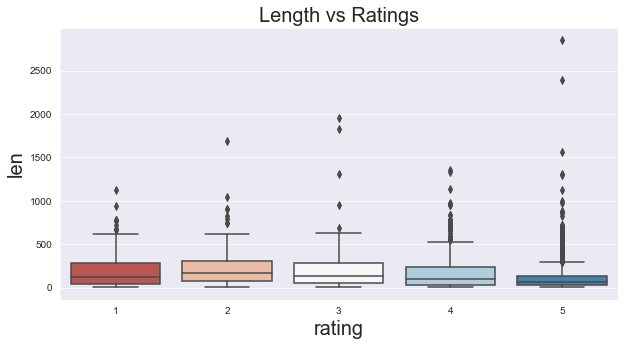

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='rating', y='len', data=df, palette='RdBu');
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.ylabel('len', fontsize=20);

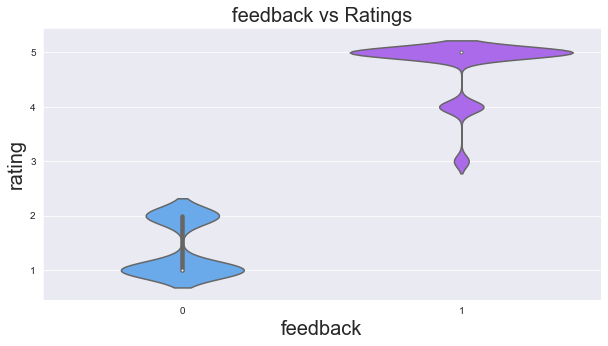

In [20]:
plt.figure(figsize=(10, 5))
sns.violinplot(data = df, x = 'feedback', y = 'rating', palette = 'cool')
plt.title("feedback vs Ratings", fontsize=20)
plt.xlabel('feedback', fontsize=20)
plt.ylabel('rating', fontsize=20);

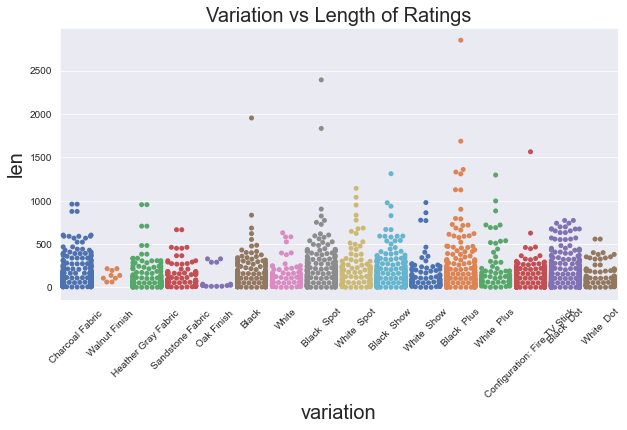

In [21]:
plt.figure(figsize=(10, 5))
sns.swarmplot(data = df, x = 'variation', y = 'len', palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation = 45);
plt.xlabel('variation', fontsize=20)
plt.ylabel('len', fontsize=20);

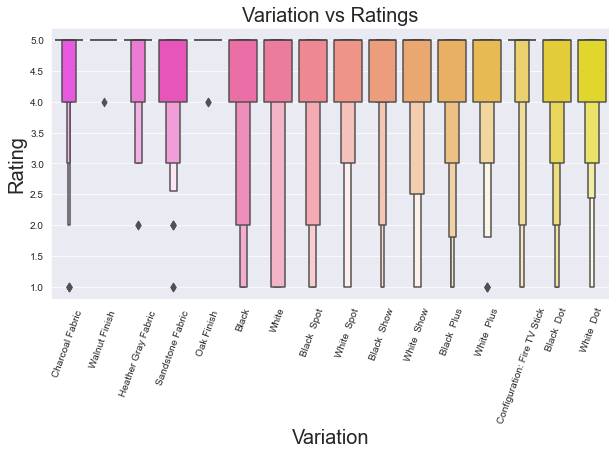

In [22]:
plt.figure(figsize=(10, 5))
sns.boxenplot(data = df, x = 'variation', y = 'rating', palette='spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation = 70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);

In [23]:
count_vector = CountVectorizer(stop_words='english') 
ws = count_vector.fit_transform(df.verified_reviews)
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key = lambda x: x[1], reverse = True)

freq = pd.DataFrame(w_f, columns=['word', 'freq'])

Text(0, 0.5, 'length')

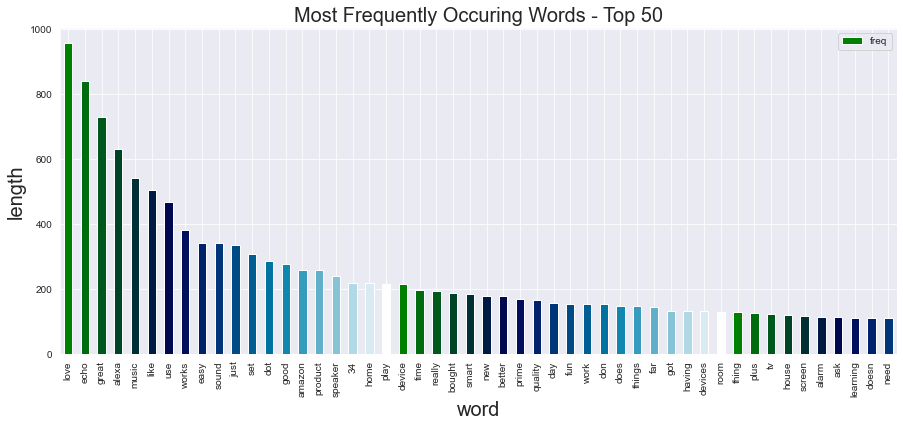

In [24]:
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('length', fontsize=20)

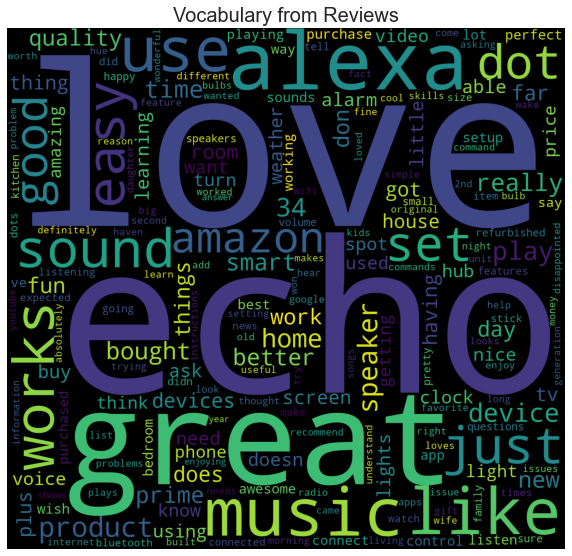

In [25]:
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [26]:
c = []
for i in range(0, 3150):
    r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])
    r = r.lower()
    r = r.split()
    ps = PorterStemmer()
    sw = stopwords.words('english')
    sw.remove('not')
    r = [ps.stem(word) for word in r if not word in set(sw)]
    r = ' '.join(r)
    c.append(r)

In [27]:
count_vector = CountVectorizer(max_features=2500) 

X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

print(X.shape)
print(y.shape)

(3150, 2500)
(3150,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (2362, 2500)
shape of X_test:  (788, 2500)


In [30]:
min_max_sc = MinMaxScaler()

X_train = min_max_sc.fit_transform(X_train)
X_test = min_max_sc.transform(X_test)

Accuracy:  0.9416243654822335


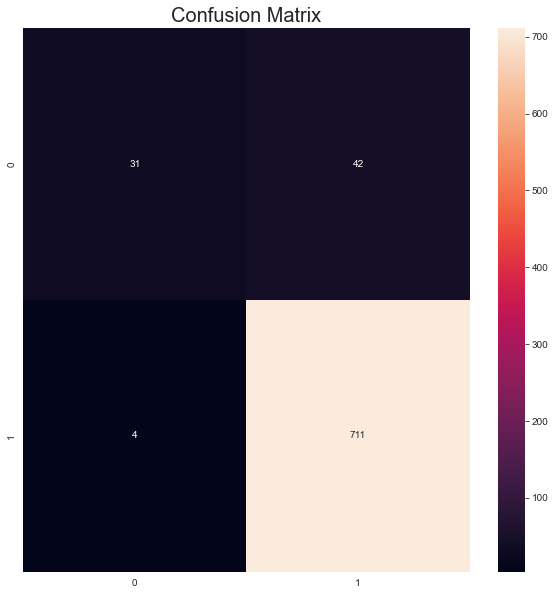

In [31]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);